In [3]:
%pylab inline
from datetime import date
from datetime import datetime
import os
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (mean_squared_error, r2_score)
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


In [4]:
##Arquitecturas
n1 = np.array([(10,5),(50,10),(100,10)])
n2 = np.array([(40,10),(60,8),(100,10)])
arqs ={"adam": n1,
      "lbfgs":n2
}

In [ ]:
#Funciones para crear matrices de entrenaminto y pruebas

In [5]:
def train_X_Y(dias, precios, d_inicial,num_samples,num_features):    ##d_inicial : 0 a 2508
    ##dias: vector de dia de la semana para cada dia (L=1...V=5)
    ##precios: vector de pecios para cada dia
    ##d_inicial: Primer dia del entrenamiento (0 a 2508) es num_features-1 dias antes que el primer Y de entrenamiento 
    ##num_samples: Número de muestras para entrenar 
    ##num_features: Número de parametros de entrenamiento (1+ número de dias con que se predice el precio)
    
    
    
    num_dias = num_features-1
   
    dias = dias[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    dias = dias.reshape(len(dias),1)
    
    pr=precios[d_inicial:d_inicial+num_samples]
    
    for i in range(d_inicial+1,d_inicial+num_dias):
        m = precios[i:i+num_samples]
        pr =  np.column_stack((pr,m))
            
    X = np.column_stack((pr,dias))
             
    Y = precios[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    
    assert (X.shape == (num_samples, num_features))
    assert (Y.shape == (num_samples,))
    
    train = {"X": X,
                "Y": Y
            }
    
    return train



def test_X_Y(dias, precios, d_inicial,num_samples,num_features):
    test = train_X_Y(dias, precios, d_inicial,num_samples,num_features)
    
    return test

def errores(Y_expected,Y_predict):
    error_RMS= np.sqrt(mean(((Y_predict-Y_expected)/Y_expected)**2))*100
    error_MBE= mean((Y_predict-Y_expected)/Y_expected)*100
    p_value = ks_2samp(Y_expected,Y_predict)[1]
    r2 = r2_score(Y_expected,Y_predict)
    
    error_RMS= np.round(error_RMS,3)
    error_MBE= np.round(error_MBE,4)
    p_value = np.round(p_value,2)
    r2 = np.round(r2,2)
                    
                    
    error = {"RMS": error_RMS,
             "MBE": error_MBE,
             "P-Value": p_value,
             "R2":r2
            }
    return error

def RMS(Y_prdct,Y):
    error = np.sqrt(sum((Y_prdct-Y)**2))/len(Y)
    return error

def graph_comb(values):
    k= np.array(values)
    sw = True

    while sw == True:
        sw = False
        for i in range(len(k)-1):
            temp1 = list(k[i])
            temp2 = list(k[i+1])
            if temp2[0]<temp1[0]:
                k[i]=temp2
                k[i+1]=temp1
                sw=True

            if temp2[0]==temp1[0]:
                if temp2[1]<temp1[1]:
                    k[i]=temp2
                    k[i+1]=temp1
                    sw=True
    a=[]
    b=[]
    i=0
    while i in range (len(k)):
        d = k[i]
        a.append(d)
        cnt=1
        l = k[i+1:]
        for j in range(len(l)):
            if sum(l[j]==d)==2:
                cnt= cnt+1
            else:
                j= len(l)
        b.append(cnt)
        i= i+cnt
    
    plt.bar(range(len(a)),b)
    plt.plot()
    plt.subplots_adjust(left=0.5, bottom=1, right=3, top=2)
    plt.show()
    print(a)
    print(b)

In [12]:
## Poblando datos

In [6]:
datos_csv = os.path.join( '.','COLCAP.csv')
datos_pd = pd.read_csv(datos_csv, sep = ',',
                encoding='latin-1', parse_dates =[0], infer_datetime_format= True)

In [7]:
a=datos_pd["Fecha (dd/mm/aaaa)"]

dias = []

for i in range(len(a)):
    d = a[i].weekday() + 1
    dias.append(d)
    
d = np.array(dias)

In [8]:
b = datos_pd["Valor COLCAP"]
b = np.array(b)
d
for i in range(len(b)):
    b[i] = b[i].replace(',',"")


p=np.array(b, dtype= np.float64)

In [9]:
## Prueba

In [76]:
## Definición de matrices de entreno
train=train_X_Y(d,p,10,2400,6)

In [77]:
#Definición de matrices de prueba
test=test_X_Y(d,p,2509-30-5,30,6)

In [96]:
#Entreno del sistema Adam
rg= None
e =10000
for i in range(100):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=arqs["lbfgs"][2],max_iter= 200, activation="relu",shuffle= False, solver= "lbfgs", warm_start= False)
        r.fit(train["X"],train["Y"])
    
    error = errores(train['Y'],r.predict(train['X']))['RMS']
    
    
    if error<e:
        e=error
        rg=r
        print(e)

1.024
1.022
1.021
1.016
1.014
1.012


In [97]:
print(rg.n_iter_)
print(e)
print(rg.solver)
print(rg.hidden_layer_sizes)

208
1.012
lbfgs
[100  10]


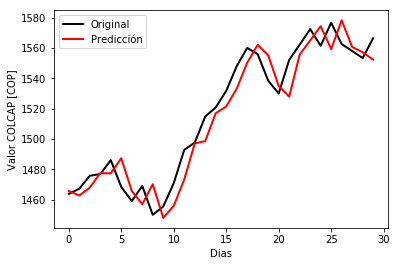

El Error RMS del entreno es: 1.012%
El Error MBE del entreno es: -0.0048%
El P-Value del entreno es: 1.0
El R^2 del entreno es: 1.0

El Error RMS de la prueba es: 0.803%
El Error MBE de la prueba es: -0.1929%
El P-Value de la prueba es: 1.0
El R^2 de la prueba es: 0.92


In [98]:
#### Grafica de predicción y real
plt.plot(test["Y"],  'k', linewidth=2)
plt.plot(rg.predict(test["X"]), 'r', linewidth=2)
plt.legend(["Original","Predicción"])
plt.xlabel("Dias")
plt.ylabel("Valor COLCAP [COP]")
error_train = errores(train['Y'],rg.predict(train['X']))
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS'])+ "%")
print("El Error MBE del entreno es: " + str(error_train['MBE'])+ "%")
print("El P-Value del entreno es: " + str(error_train['P-Value']))
print("El R^2 del entreno es: " + str(error_train['R2']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS'])+ "%")
print("El Error MBE de la prueba es: " + str(error_test['MBE'])+ "%")
print("El P-Value de la prueba es: " + str(error_test['P-Value']))
print("El R^2 de la prueba es: " + str(error_test['R2']))

[(10, 8), (10, 7), (10, 9), (10, 5), (10, 8), (10, 2), (10, 7), (20, 9), (10, 9), (10, 5), (10, 7), (10, 10), (10, 7), (20, 3), (10, 5), (60, 5), (10, 10), (30, 5), (30, 6), (10, 7)]


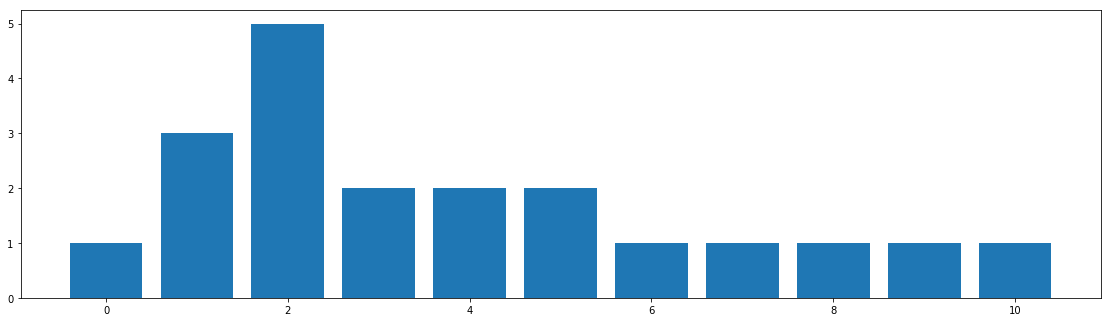

[array([10,  2]), array([10,  5]), array([10,  7]), array([10,  8]), array([10,  9]), array([10, 10]), array([20,  3]), array([20,  9]), array([30,  5]), array([30,  6]), array([60,  5])]
[1, 3, 5, 2, 2, 2, 1, 1, 1, 1, 1]


In [107]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='adam')
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(20):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
    c.append(clf.best_params_['hidden_layer_sizes'])
    
print(c)
graph_comb(c)

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
[(20, 8), (30, 9), (40, 8), (80, 9), (50, 9), (20, 9), (100, 9), (10, 10), (50, 5), (70, 9), (10, 5), (40, 4), (40, 10), (100, 6), (20, 5), (60, 6), (50, 5), (80, 4), (60, 6), (100, 7)]


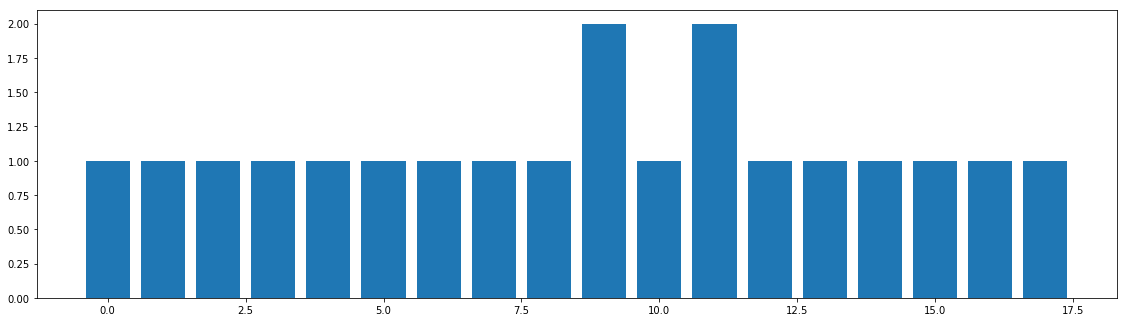

[array([10,  5]), array([10, 10]), array([20,  5]), array([20,  8]), array([20,  9]), array([30,  9]), array([40,  4]), array([40,  8]), array([40, 10]), array([50,  5]), array([50,  9]), array([60,  6]), array([70,  9]), array([80,  4]), array([80,  9]), array([100,   6]), array([100,   7]), array([100,   9])]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


In [111]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='lbfgs')
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(20):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
            
    c.append(clf.best_params_['hidden_layer_sizes'])

c1 = list(c)    
print(c1)
graph_comb(c1)    